# Protein Secondary Structure Prediction
paper : https://www.ijcai.org/Proceedings/16/Papers/364.pdf

git : 

In [227]:
import os, sys
sys.path.append('../src/')
import numpy as np
import glob
import pandas as pd
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
from data import *
from model import Net
from download_dataset import download_dataset
from sklearn.model_selection import KFold
from download_dataset import get_train
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from visualize import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data visualization

### data loader for data visualization

In [10]:
D = LoadDataset(batch_size_train=6048, batch_size_test=1)
idxs = np.arange(D.__len__())
data_loader, _ = D([idxs, idxs])

In [4]:
data, target, seq_len = next(iter(data_loader))
data, target, seq_len = data.data.numpy(), target.data.numpy(), seq_len.data.numpy()

### sequence length

max:700, min:12, mean:209


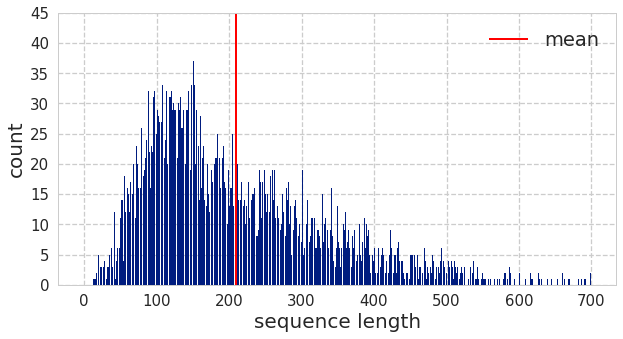

In [14]:
print(f'max:{seq_len.max()}, min:{seq_len.min()}, mean:{seq_len.mean().astype(int)}')
seq_len_plot(seq_len)

### rate of amino acid residues

In [167]:
amino_rate = np.zeros(8)
for t, l in zip(target, seq_len):
    t = t[:l]
    keys, values = amino_count(t)
    amino_rate[keys] += values
amino_rate /= seq_len.sum()

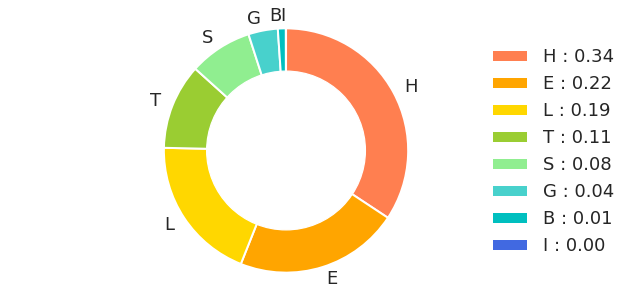

In [170]:
amino_rate_plot(amino_rate)

## Network

In [198]:
Net()

Net(
  (conv1): Sequential(
    (0): Conv1d(42, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(42, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(42, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): ReLU()
  )
  (brnn): GRU(192, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=704, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=8, bias=True)
    (3): ReLU()
  )
)

## Result

### history plot

In [202]:
result_path = '../data/result_201808052028'
history_path = glob.glob(os.path.join(result_path, 'history*'))

# history : (train_loss, test_loss, acc)
history = np.array([np.load(h_path) for h_path in history_path])

history_0


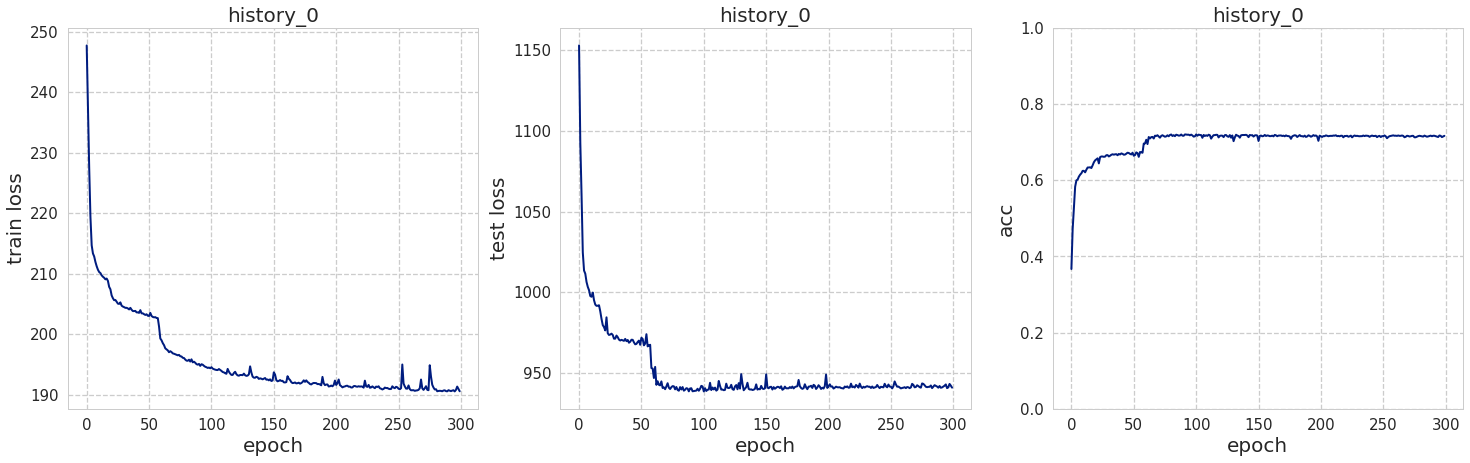

history_1


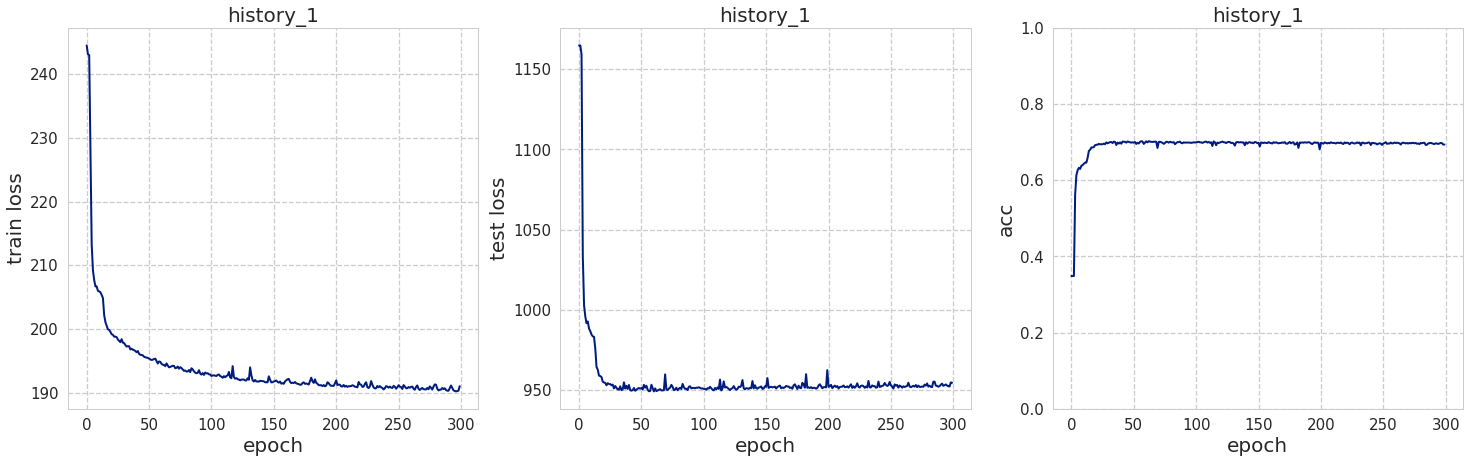

history_2


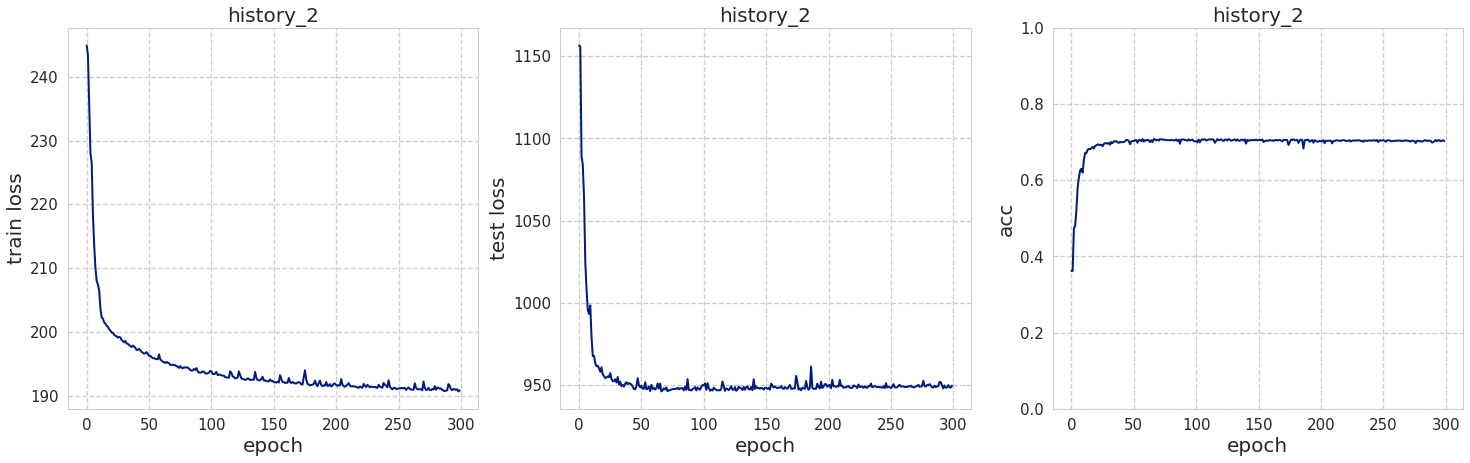

history_3


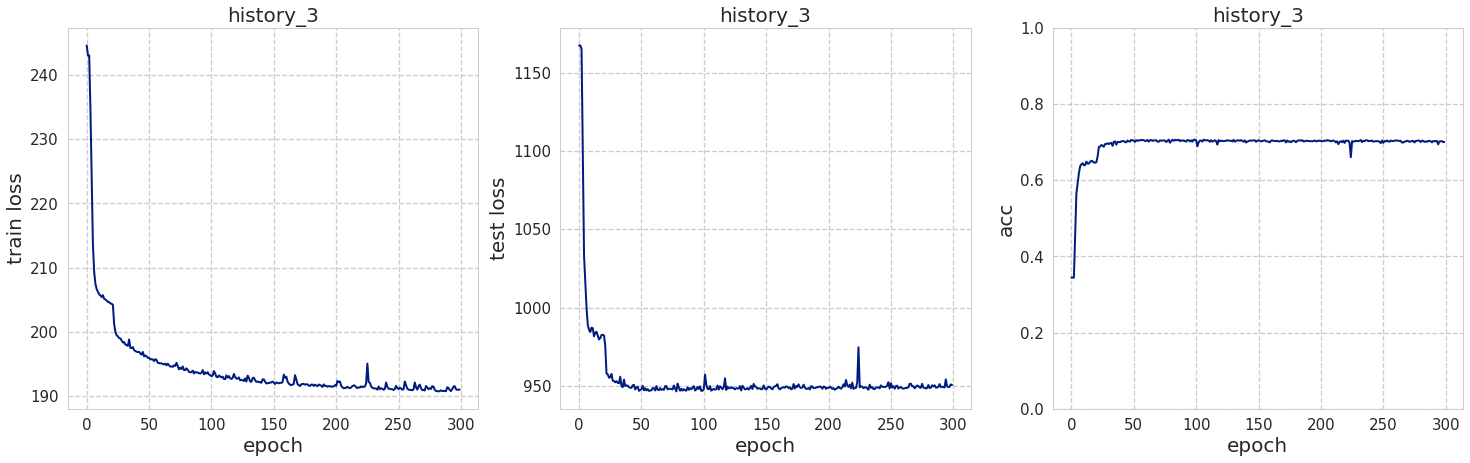

history_4


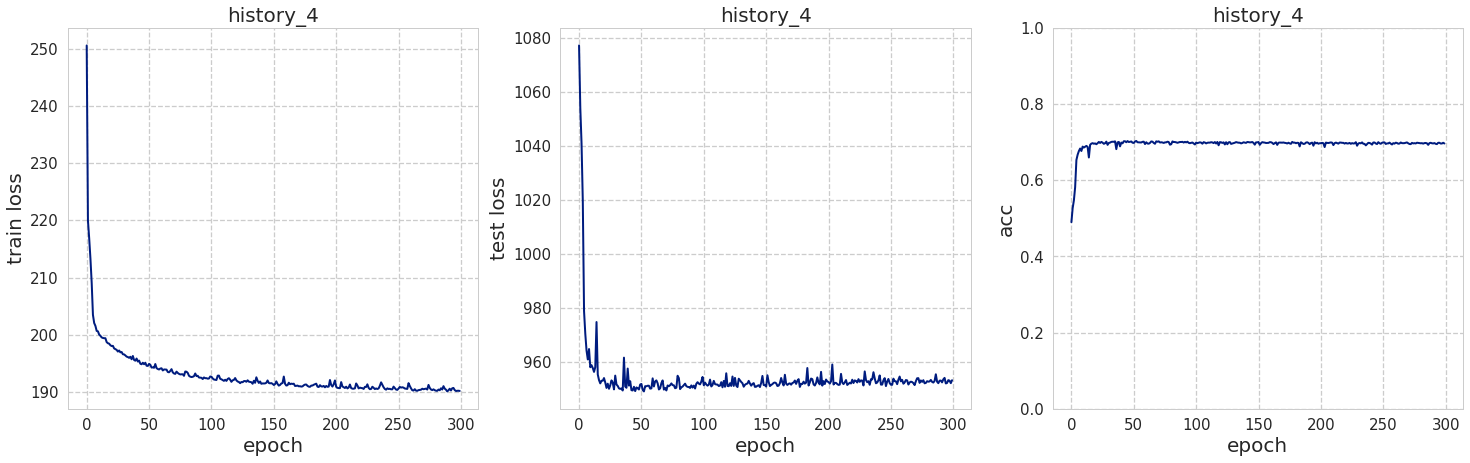

history_5


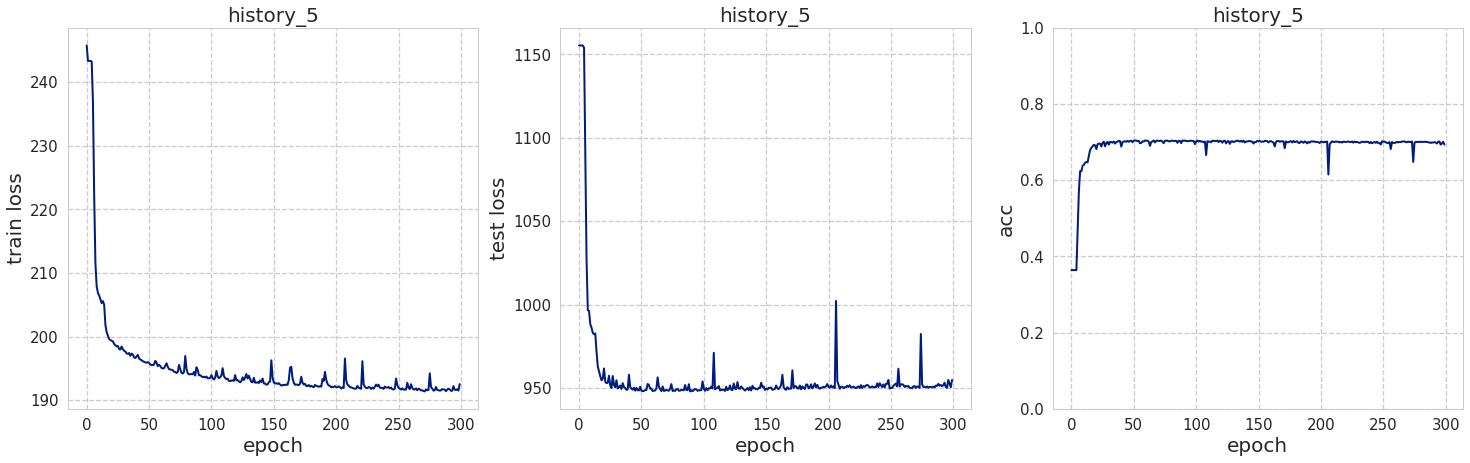

history_6


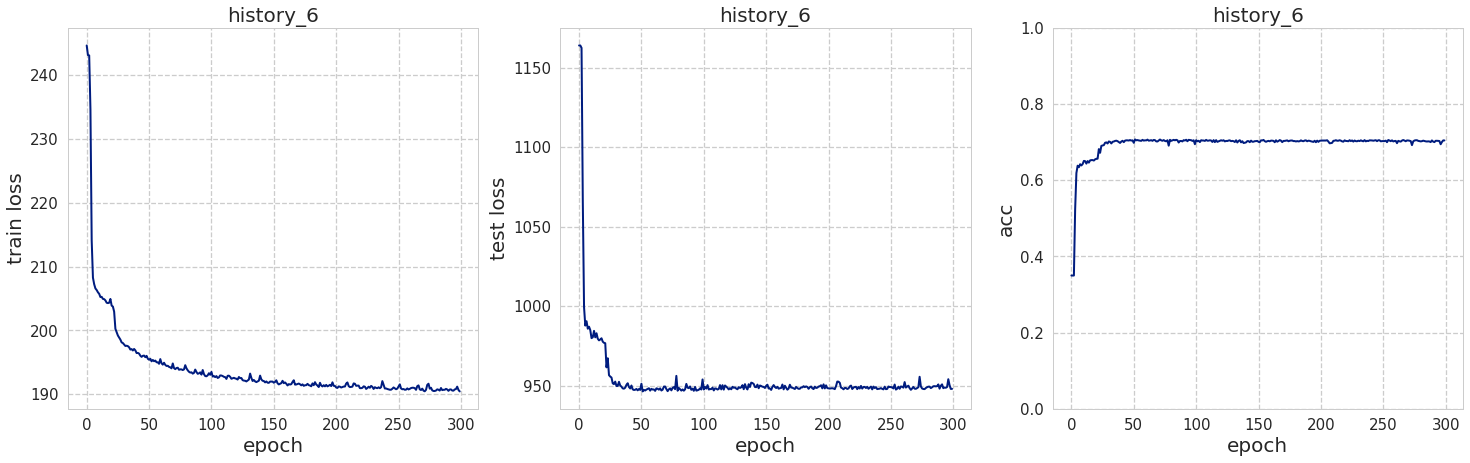

history_7


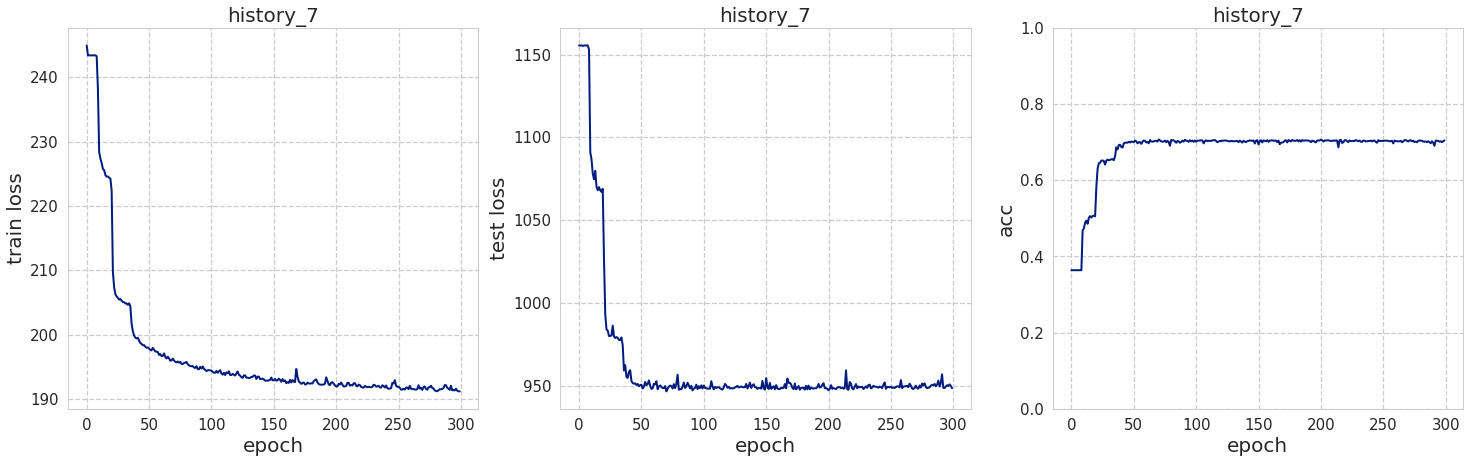

history_8


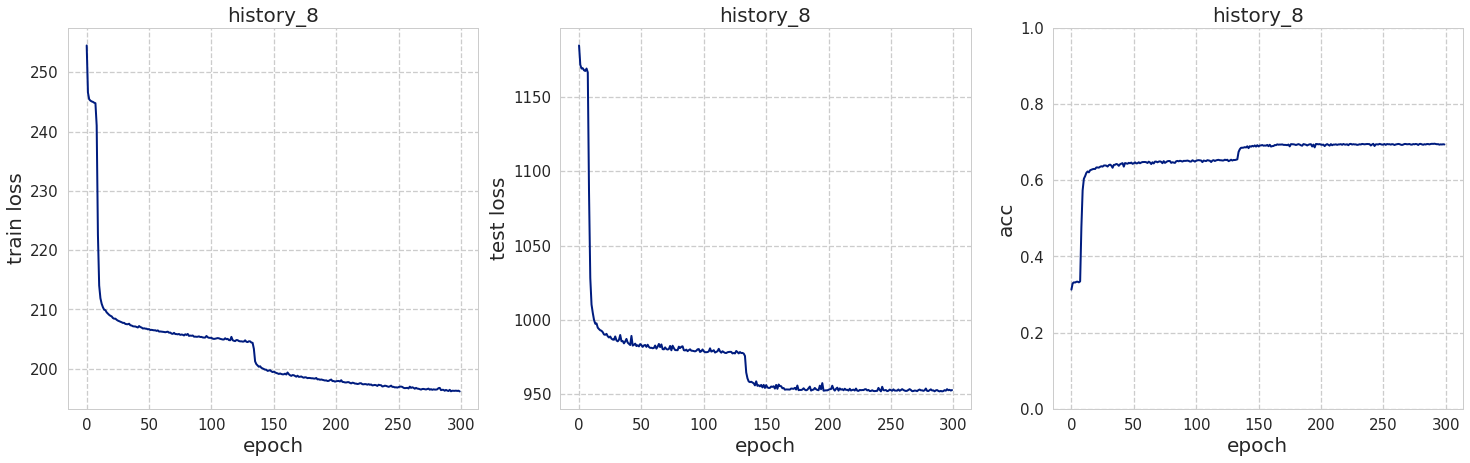

history_9


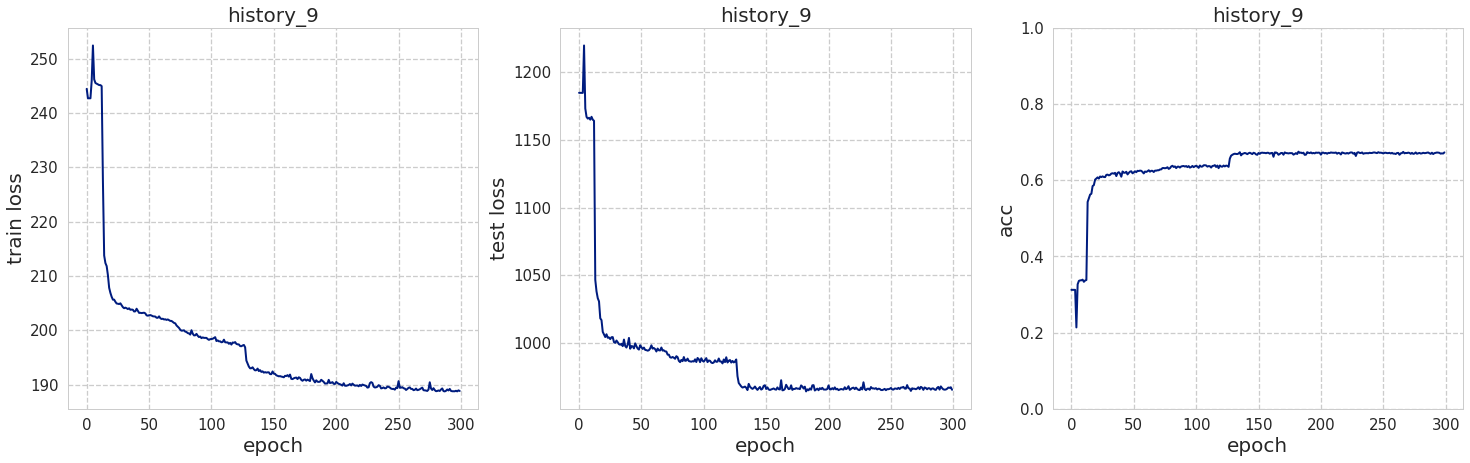

In [201]:
for h, h_path in zip(history, history_path):
    title, _ = os.path.basename(h_path).split('.')
    print(title)
    history_plot(h.T, title=title, show=True, save=False, save_path='')

### Accuracy

In [203]:
acc = np.array([max(h.T[2]) for h in history])
df_acc = pd.DataFrame({'acc' : acc,
                       'model' : 'CNN-BGRU'})

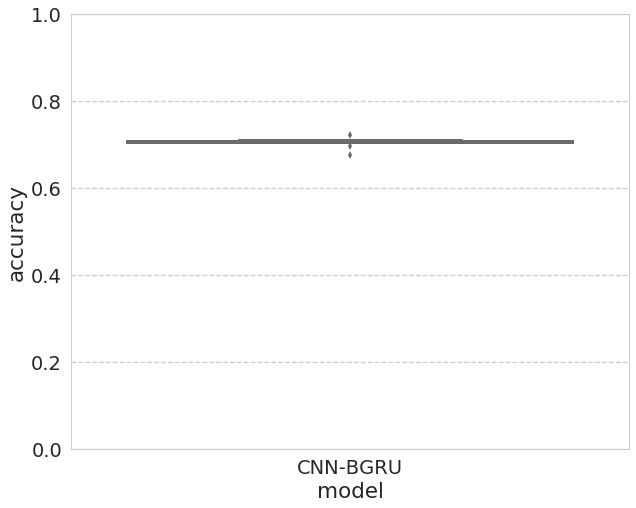

In [225]:
acc_plot(df_acc)

In [232]:
acc_each = np.load(save_path)
keys = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
df = pd.DataFrame({'acc' : acc_each.reshape(-1),
                   'amino_acid' : keys * 10})

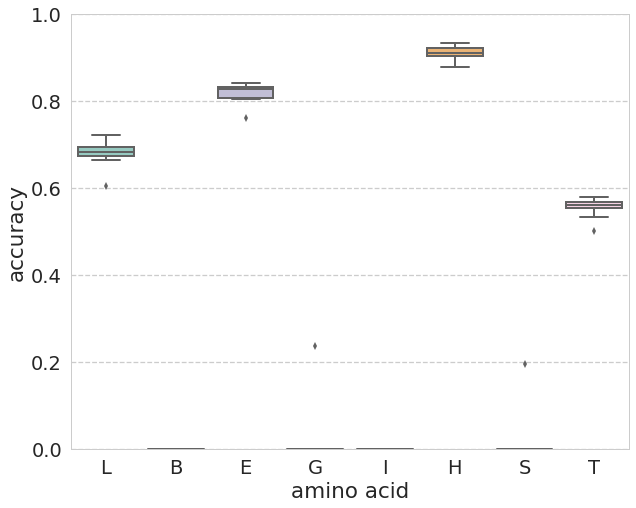

In [233]:
acc_each_plot(df)

## device

In [175]:
use_cuda = not False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## model

In [9]:
params = torch.load('../data/result_201808052028/model_1.pth')

In [15]:
model = Net().to(device)
model.load_state_dict(params)
optm = torch.optim.Adam(model.parameters())

In [127]:
model.eval()
acid_acc = np.zeros(9)
len_ = len(test_loader)
with torch.no_grad():
    for i, (data, target, seq_len) in enumerate(test_loader):
        data, target, seq_len = data.to(device), target.to(device), seq_len.to(device)
        out = model(data)
        acid_acc += acid_accuracy(out, target, seq_len)

In [128]:
acid_acc

array([0.9       , 0.        , 0.3       , 0.        , 0.        ,
       1.        , 0.        , 0.55555556, 0.        ])

## Acid accuracy

In [171]:
def test_(model, device, test_loader):
    model.eval()
    acid_acc = np.zeros(8)
    len_ = len(test_loader)
    with torch.no_grad():
        for i, (data, target, seq_len) in enumerate(test_loader):
            data, target, seq_len = data.to(device), target.to(device), seq_len.to(device)
            out = model(data)
            acid_acc += acid_accuracy(out, target, seq_len)
    acid_acc /= len_
    return acid_acc

In [172]:
result_path = '../data/result_201808052028'
param_path = glob.glob(os.path.join(result_path, 'model*'))

In [173]:
kf = KFold(10)
D = LoadDataset(batch_size_train=64, batch_size_test=1024)
idxs = np.arange(D.__len__())
kf = KFold(n_splits=10)

In [176]:
acid_acc_history = []
for k, idx in enumerate(kf.split(idxs)):
    _, test_loader = D(idx)
    
    params = torch.load(param_path[k])
    model = Net().to(device)
    model.load_state_dict(params)
    
    acid_acc = test_(model, device, test_loader)
    acid_acc_history.append(acid_acc)

In [177]:
save_path = os.path.join(result_path, 'acid_acc.npy')
np.save(save_path, acid_acc_history)

In [178]:
acid_acc = np.load(save_path)

In [179]:
keys = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
values = acid_acc

In [180]:
df = pd.DataFrame({'amino_acid' : keys * 10,
                  'acc' : values.reshape(-1)})

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

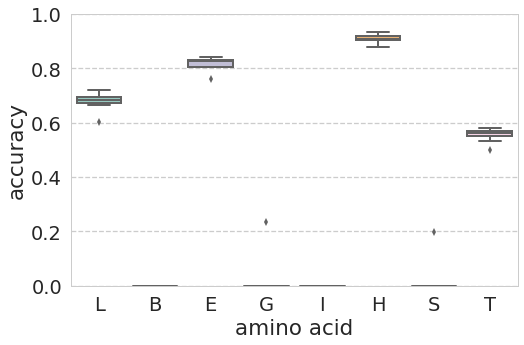

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x='amino_acid', y='acc', data=df, order=keys, ax=ax, palette="Set3")
ax.set_xlabel('amino acid')
ax.set_ylabel('accuracy')
ax.set_ylim(0, 1)
plt.show()